## Outlier Detection - One Class SVM

In [1]:
#Import the libraries needed
import pandas as pd
import glob
import numpy as np
import time
import re
from sklearn import svm
import os
import xml.etree.ElementTree as et
from nilearn import image
from nilearn import plotting

In [2]:
#Paths of input and output files
#path - the path of input file 
#path_iqr - path of output file
current_dir = os.getcwd()
# print(current_dir)
path = os.path.join(current_dir,'fcon1000_Beijing_zang_stats')
path_iqr = os.path.join(current_dir,'fcon1000_Beijing_zang_stats_svm')

In [3]:
#Output file directory 
#Removing all files already in the directory
opdir_avl_files = glob.glob(path_iqr+"/*.txt")
# print(opdir_avl_files)
for f in opdir_avl_files:
    os.remove(f)

In [4]:
#Reading the input files 
#Find all the files 
allFiles = glob.glob(path + "/*.txt")
# Split into train and test files in random - test:train :: 0.1:0.9
# train_files - contains all training file names 
# test_files - contains all test file names
import random
num_tot_files = len(allFiles)
# num_test_files = int(0.1*num_tot_files)
# print(num_tot_files,num_test_files)
# test_file_index = random.sample(range(len(allFiles)), num_test_files)
# print(test_file_index)

In [5]:
#Read the test file 
test_file_path = os.path.join(current_dir,'2523412_edited.roiwise.stats.txt')
test_df = pd.read_csv(test_file_path,header=0,delimiter='\t')
test_df = test_df[test_df['ROI_ID']!=900] #removing cerebellum
test_df.drop(columns='CSF_Volume(mm^3)',inplace=True) #removing CSF_Volume
#         Normalizing by volume per subject across all rois
tot_vol1 = test_df['Total_Volume(GM+WM)(mm^3)'].sum()
for item in test_df.columns:
    if(item!='ROI_ID'):
        test_df.loc[:,str(item)] /= tot_vol1
unique_roi_test = test_df.ROI_ID.unique()
for i in range(len(unique_roi_test)):
    unique_roi_test[i] = int (unique_roi_test[i]);

In [6]:
test_df

,ROI_ID,Mean_Thickness(mm),GM_Volume(mm^3),WM_Volume(mm^3),Total_Volume(GM+WM)(mm^3),Cortical_Area_mid(mm^2),Cortical_Area_inner(mm^2),Cortical_Area_pial(mm^2)
0,1,NaN,0.000000,0.000000,0.106899,0.000000,0.000000,0.000000
1,2,NaN,0.261977,0.000000,0.261977,0.000000,0.000000,0.000000
2,3,0.000000,0.000000,0.209512,0.209512,0.000000,0.000000,0.000000
3,120,0.000002,0.011978,0.005989,0.017967,0.003095,0.002547,0.004117
4,121,0.000002,0.012435,0.006332,0.018767,0.003153,0.002524,0.004288
5,130,0.000002,0.006067,0.002981,0.009048,0.001669,0.001344,0.002345
6,131,0.000002,0.005815,0.002881,0.008695,0.001582,0.001286,0.002173
7,142,0.000002,0.001785,0.000944,0.002730,0.000506,0.000442,0.000650
8,143,0.000002,0.001881,0.001132,0.003012,0.000538,0.000486,0.000697
9,144,0.000002,0.003117,0.001707,0.004824,0.000882,0.000730,0.001210


Training files

In [7]:
# Reading each file as a dataframe, and storing it in a list
fileslist = []
frame = pd.DataFrame()
for i in range(len(allFiles)):
    
    file = allFiles[i]
#     print(file)
    df = pd.read_csv(file,index_col=None, header=0,delimiter='\t')
    df = df[df['ROI_ID']!=900] #removing cerebellum
    df.drop(columns='CSF_Volume(mm^3)',inplace=True) #removing CSF_Volume
    #Normalizing by volume per subject across all rois
    tot_vol = df['Total_Volume(GM+WM)(mm^3)'].sum()
#     print(tot_vol)
    for item in df.columns:
        if(item!='ROI_ID'):
            df.loc[:,str(item)] /= tot_vol
    
    fileslist.append(df)
# print(len(fileslist))

In [8]:
df

,ROI_ID,Mean_Thickness(mm),GM_Volume(mm^3),WM_Volume(mm^3),Total_Volume(GM+WM)(mm^3),Cortical_Area_mid(mm^2),Cortical_Area_inner(mm^2),Cortical_Area_pial(mm^2)
0,1,NaN,0.000000,0.000000e+00,0.071070,0.000000,0.000000,0.000000
1,2,NaN,0.255838,0.000000e+00,0.255838,0.000000,0.000000,0.000000
2,3,0.000000,0.000000,2.319724e-01,0.231972,0.000000,0.000000,0.000000
3,120,0.000002,0.012273,8.189240e-03,0.020462,0.003625,0.003105,0.004657
4,121,0.000002,0.011860,6.890001e-03,0.018750,0.003459,0.002885,0.004521
5,130,0.000002,0.006710,3.854922e-03,0.010565,0.001987,0.001660,0.002607
6,131,0.000002,0.006144,4.236276e-03,0.010380,0.001887,0.001730,0.002350
7,142,0.000002,0.001593,1.175786e-03,0.002769,0.000474,0.000439,0.000567
8,143,0.000002,0.002169,1.742632e-03,0.003912,0.000673,0.000618,0.000834
9,144,0.000002,0.001907,1.116236e-03,0.003023,0.000616,0.000538,0.000805


In [9]:
#Convert the list into a vertical stack, and find the column headers
data_2d_array = np.vstack(fileslist)
data_vstack = pd.DataFrame(data_2d_array)
# print(data_vstack.shape)
data_vstack.columns = df.columns.values.tolist()

In [10]:
#Find the unique ROI_IDs and store it 
unique_roi = data_vstack.ROI_ID.unique()
for i in range(len(unique_roi)):
    unique_roi[i] = int (unique_roi[i]);

In [11]:
#Common ROI_IDs in both test and train files 
common_roi = list(set(unique_roi).intersection(unique_roi_test))

In [12]:
# print(unique_roi_test)
# print('Length:',len(unique_roi_test))

In [13]:
#3D dataframe to be implemented using Panels. Hence reordering the index.
#Data is grouped by ROI_ID. Dict keys are ROI_IDs.
temp_df = pd.DataFrame()
temp_dict = {}
for i in range(len(common_roi)):
    each_roi = common_roi[i]
    temp_df = data_vstack[data_vstack['ROI_ID'] == each_roi]
    index_range = range(temp_df.shape[0])
    temp_df['new_ind'] = index_range
    temp_df.set_index('new_ind',inplace=True)
    temp_dict[each_roi] = temp_df
#     print(temp_df)

C:\Users\Muthulakshmi C\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [14]:
#Create a panel from the dictionary
p = pd.Panel(temp_dict)
# print(p)

C:\Users\Muthulakshmi C\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3267: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
# print(p)

Test files - Pre process

In [16]:
# Reading each test file as a dataframe, and storing it in a list
testfileslist = []
# testframe = pd.DataFrame()
# for i in range(len(allFiles)):
#     if i in test_file_index:
#         file = allFiles[i]
#     #     print(file)
#         tdf = pd.read_csv(file,index_col=None, header=0,delimiter='\t')
#         testfileslist.append(df)
# # print(len(testfileslist))
testfileslist.append(test_df)

In [17]:
#Convert the list into a vertical stack, and find the column headers
tdata_2d_array = np.vstack(testfileslist)
tdata_vstack = pd.DataFrame(tdata_2d_array)
# print(data_vstack.shape)
tdata_vstack.columns = test_df.columns.values.tolist()

In [18]:
#3D dataframe to be implemented using Panels. Hence reordering the index.
#Data is grouped by ROI_ID. Dict keys are ROI_IDs.
ttemp_df = pd.DataFrame()
ttemp_dict = {}
for i in range(len(common_roi)):
    each_roi = common_roi[i]
    ttemp_df = tdata_vstack[tdata_vstack['ROI_ID'] == each_roi]
    tindex_range = range(ttemp_df.shape[0])
    ttemp_df['new_ind'] = tindex_range
    ttemp_df.set_index('new_ind',inplace=True)
    ttemp_dict[each_roi] = ttemp_df
#     print(temp_df)

C:\Users\Muthulakshmi C\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
#Create a panel from the dictionary
ptest = pd.Panel(ttemp_dict)
# print(p)

In [20]:
# ptestnew

One class SVM : Training and test files

In [38]:
#Make a copy of the panel. 
#Find IQR of each column for the specified quartiles. 
#Check if each entry is in the IQR - output False if no outlier, 
#True if it is an outlier. 
p_new = p
ptestnew = ptest
model = svm.OneClassSVM(nu=0.001, kernel='linear', gamma=0.0000001)  
result_list = []
for i in range(len(common_roi)) :
    each_roi = common_roi[i]
    df = p_new[each_roi]
    df1 = df.drop(columns = 'ROI_ID',inplace=False)
    df1.dropna(inplace=True,axis=1)
    model.fit(df1)
    tdf = ptestnew[each_roi]
    tdf1 = tdf.drop(columns = 'ROI_ID',inplace=False)
    tdf1.dropna(inplace=True,axis=1)
    result = model.predict(tdf1)
    
#     print()
    result_list.append(list(result))
    print("ROI:",each_roi,",",result[0],",",model.score_samples(tdf1))
# print(result_list)

ROI: 1 , 1 , [0.0015973]
ROI: 2 , 1 , [0.02085387]
ROI: 3 , 1 , [0.01381155]
ROI: 612 , -1 , [6.36293073e-07]
ROI: 613 , -1 , [6.80906029e-07]
ROI: 614 , -1 , [8.33022852e-07]
ROI: 615 , -1 , [7.25006021e-07]
ROI: 616 , 1 , [1.39229209e-07]
ROI: 617 , 1 , [1.11374545e-07]
ROI: 620 , 1 , [1.32253499e-09]
ROI: 621 , -1 , [1.06963007e-09]
ROI: 120 , 1 , [8.52796939e-05]
ROI: 121 , 1 , [7.74652999e-05]
ROI: 640 , -1 , [1.71702686e-06]
ROI: 641 , -1 , [1.9483966e-06]
ROI: 130 , -1 , [2.3782234e-05]
ROI: 131 , -1 , [2.68686071e-05]
ROI: 142 , 1 , [1.90240294e-06]
ROI: 143 , -1 , [3.02290452e-06]
ROI: 144 , 1 , [3.54179781e-06]
ROI: 145 , 1 , [2.76855311e-06]
ROI: 146 , -1 , [4.1831636e-07]
ROI: 147 , 1 , [2.21961645e-07]
ROI: 150 , -1 , [2.62553461e-05]
ROI: 151 , -1 , [2.11704929e-05]
ROI: 670 , -1 , [1.96528646e-09]
ROI: 671 , -1 , [1.98314222e-09]
ROI: 162 , 1 , [6.8096351e-07]
ROI: 163 , -1 , [5.50831795e-07]
ROI: 164 , 1 , [1.72368808e-06]
ROI: 165 , 1 , [1.75430191e-06]
ROI: 166 , 1 , 

In [22]:
p[229]

,ROI_ID,Mean_Thickness(mm),GM_Volume(mm^3),WM_Volume(mm^3),Total_Volume(GM+WM)(mm^3),Cortical_Area_mid(mm^2),Cortical_Area_inner(mm^2),Cortical_Area_pial(mm^2)
new_ind,,,,,,,,
0,229.0,0.000001,0.005409,0.003132,0.008541,0.001943,0.001673,0.002494
1,229.0,0.000002,0.004984,0.003055,0.008038,0.001686,0.001532,0.002144
2,229.0,0.000002,0.005102,0.003389,0.008492,0.002077,0.001785,0.002681
3,229.0,0.000002,0.005117,0.002901,0.008018,0.001749,0.001503,0.002284
4,229.0,0.000002,0.005990,0.003255,0.009245,0.002100,0.001782,0.002750
5,229.0,0.000002,0.006554,0.004405,0.010960,0.002431,0.002197,0.003074
6,229.0,0.000001,0.004026,0.002812,0.006838,0.001459,0.001316,0.001892
7,229.0,0.000002,0.005009,0.003291,0.008300,0.001857,0.001603,0.002486
8,229.0,0.000002,0.004838,0.002683,0.007521,0.001611,0.001332,0.002245


In [23]:
ptestnew[229]

,ROI_ID,Mean_Thickness(mm),GM_Volume(mm^3),WM_Volume(mm^3),Total_Volume(GM+WM)(mm^3),Cortical_Area_mid(mm^2),Cortical_Area_inner(mm^2),Cortical_Area_pial(mm^2)
new_ind,,,,,,,,
0,229.0,0.000001,0.004083,0.002522,0.006604,0.00152,0.001349,0.001943


In [24]:
result_df = pd.DataFrame(result_list)
result_df['ROI_ID'] = common_roi
# result_df.set_index('new_ind',inplace=True)
# print(result_df)

In [25]:
# result_df[result_df[0]==-1]

In [26]:
outlier_df = result_df[result_df[0]==-1]
outlier_roi= outlier_df['ROI_ID'].tolist()
print(outlier_roi)
print(len(outlier_roi))

[612, 613, 614, 615, 621, 640, 641, 130, 131, 143, 146, 150, 151, 670, 671, 163, 167, 172, 173, 680, 681, 690, 691, 182, 183, 186, 187, 720, 222, 223, 226, 227, 228, 229, 242, 243, 800, 322, 323, 324, 325, 330, 343, 344, 345, 346, 347, 422, 423, 424, 443, 444, 445, 446, 447, 2000, 501]
57


Create a dictionary of ROI_IDs and their names from the .xml file

In [27]:
roi_dict={}
current_path = os.getcwd()
xml_file = os.path.join(os.getcwd(),'labels.xml')
root = et.parse(xml_file).getroot()
for roi in root.findall('label'):
#     print(roi)
    att = roi.attrib
#     print('ROI:',att)
    roi_id = int(att.get('id'))
    roi_name = att.get('fullname')
#     print('ROI:',roi_id,"--",roi_name)
    roi_dict[roi_id] = roi_name
# print(roi_desc)

Write Output files 

In [28]:
#Write to file 
with open("svm_edited.txt",'w') as file:
    file.write("ROI_ID\tROI_Name\n")
    for item in outlier_roi:
            roi_id = int(item)
#                 print(roi_id)
            roi_name = roi_dict[roi_id]
#             file.write(item+"\n")
            file.write(str(roi_id)+"\t"+str(roi_name)+"\n")
            print(roi_id,roi_name)
    
#     with open(testFiles_new[i],'w') as file:

612 R. caudate nucleus
613 L. caudate nucleus
614 R. putamen
615 L. putamen
621 L. nucleus accumbens
640 R. thalamus
641 L. thalamus
130 R. middle frontal gyrus
131 L. middle frontal gyrus
143 L. pars opercularis
146 R. pars orbitalis
150 R. pre-central gyrus
151 L. pre-central gyrus
670 R. superior colliculus
671 L. superior colliculus
163 L. transvers frontal gyrus
167 L. middle orbito-frontal gyrus
172 R. lateral orbitofrontal gyrus
173 L. lateral orbitofrontal gyrus
680 R. inferior colliculus
681 L. inferior colliculus
690 R. mamillary body
691 L. mamillary body
182 R. paracentral lobule
183 L. paracentral lobule
186 R. subcallosal gyrus
187 L. subcallosal gyrus
720 R. lateral ventricle
222 R. post-central gyrus
223 L. post-central gyrus
226 R. angular gyrus
227 L. angular gyrus
228 R. superior parietal gyrus
229 L. superior parietal gyrus
242 R. pre-cuneus
243 L. pre-cuneus
800 Brainstem
322 R. superior temporal gyrus
323 L. superior temporal gyrus
324 R. transverse temporal gyrus

Open the actual image, and then the outlier image

(128, 256, 256)


C:\Users\Muthulakshmi C\Anaconda3\lib\site-packages\scipy\ndimage\measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
C:\Users\Muthulakshmi C\AppData\Roaming\Python\Python37\site-packages\nilearn\plotting\displays.py:600: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(axes, collections.Sequence):


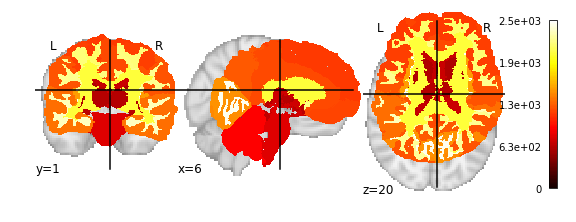

In [29]:
path = os.path.join(current_dir,'2523412.svreg.label.nii.gz')
labeldata = image.load_img(path)
print(labeldata.shape)
plotting.plot_stat_map(labeldata)

In [30]:
lda = labeldata.get_data()
print(lda)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [31]:
# laff = labeldata.header
# print(laff)

In [32]:
ld = np.isin(lda, outlier_roi)

In [33]:
print(np.where(ld)[0])

[ 23  23  23 ... 104 104 105]


In [34]:
# d1,d2,d3 = lda.shape
# for i in range(d1):
#     for j in range(d2):
#         for k in range(d3):
#             value = lda[i,j,k]
#             if value in outlier_roi:
#                 lda[i,j,k] = 250
#             else:
#                 lda[i,j,k] = 100
            

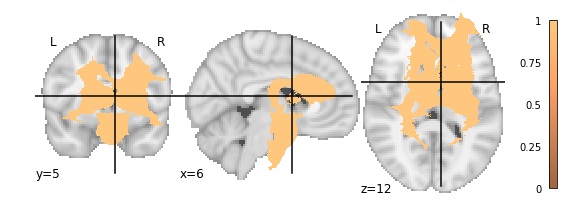

In [35]:
new_lda = image.new_img_like(labeldata, ld, affine=None, copy_header=True)
plotting.plot_stat_map(new_lda,cmap='copper')

In [36]:
new_lda.to_filename('svm_edited.svreg.label.nii.gz')